In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Load sample train data set

In [2]:
from create_Tatoeba_train_test import get_language_mappings, get_sentence_word_char_len

In [3]:
language_mappings = get_language_mappings("language_mappings.csv")
iso_639_2_English = language_mappings[["ISO 639-2", "English Name"]].set_index(keys="ISO 639-2")["English Name"].to_dict()
# iso_639_2_English

In [4]:
sample = pd.read_csv("output/Tatoeba_stratify_train_2021-7-30_1247.csv")
sample["Language_English_Name"] = sample["Language"].map(iso_639_2_English)
sample["Sentence_len"] = sample.apply(lambda row: get_sentence_word_char_len(row), axis=1)

In [5]:
bin_labels = ["1","2","3","4","5","6","7","8","9","10","11 to 16", "17 to 27", "28 to 48", "49 to 99"]

sample["Sentence_len_bin"] = pd.cut(
    x=sample["Sentence_len"],
    bins=[0,1,2,3,4,5,6,7,8,9,10,16,27,48,99],
    labels=bin_labels
)
# sample.sample(10)

In [6]:
round(sample["Language_English_Name"].value_counts(normalize=True) * 100,2)

Japanese      9.09
Chinese       9.09
Danish        9.09
Korean        9.09
Spanish       9.09
French        9.09
Dutch         9.09
Italian       9.09
German        9.09
Portuguese    9.09
English       9.09
Name: Language_English_Name, dtype: float64

# langid

#### Setup for langid

In [7]:
from langid.langid import LanguageIdentifier, model

In [8]:
iso_639_2_iso_639_1 = language_mappings[["ISO 639-2", "ISO 639-1"]].set_index(keys="ISO 639-2")["ISO 639-1"].to_dict()
# iso_639_2_iso_639_1

In [9]:
# find all languages to include in langid predictions
set_languages = [iso_639_2_iso_639_1[i] for i in sample["Language"].unique().tolist()]

lang_identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
# lang_identifier.set_languages(set_languages)

> if we cannot limit all language prediction libraries then don't limit any (?)

#### Generate langid predictions

In [10]:
%%time
# 14s, with limited languages
# 2min, 45s, with no limits on languages

sample["langid"] = sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)

Wall time: 2min 50s


In [11]:
sample["langid_language"], sample["langid_score"] = sample["langid"].str
sample.drop(columns=["langid"], inplace=True)

In [12]:
# map Language to English Name & langid_language to English Name
ISO_639_2 = language_mappings.set_index("ISO 639-2")
ISO_639_2 = ISO_639_2["English Name"].to_dict()
sample["Language_English_Name"] = sample["Language"].map(ISO_639_2)

ISO_639_1 = language_mappings.set_index("ISO 639-1")
ISO_639_1 = ISO_639_1["English Name"].to_dict()
sample["langid_language_English_Name"] = sample["langid_language"].map(ISO_639_1)

In [13]:
# round(sample["langid_language_English_Name"].value_counts(normalize=True, dropna=False) * 100,2)
round(sample["langid_language_English_Name"].value_counts(normalize=True, dropna=False) * 100,2)

Japanese             9.48
English              9.22
French               9.12
German               9.10
Korean               9.09
Dutch                8.90
Italian              8.90
Spanish              8.79
Chinese              8.71
Portuguese           8.46
Danish               6.24
Norwegian            1.80
Norwegian Bokmål     0.87
Galician             0.44
Catalan              0.15
Afrikaans            0.07
Norwegian Nynorsk    0.07
Esperanto            0.07
Romanian             0.04
Occitan              0.04
Breton               0.03
Hungarian            0.03
Swedish              0.03
Lithuanian           0.03
Aragonese            0.03
Polish               0.02
Basque               0.02
Indonesian           0.02
Walloon              0.02
Irish                0.02
Kurdish              0.01
Slovenian            0.01
Slovak               0.01
Malay                0.01
Malagasy             0.01
Finnish              0.01
Estonian             0.01
Luxembourgish        0.01
Croatian    

# langdetect

In [14]:
from langdetect import DetectorFactory
DetectorFactory.seed = 7

In [15]:
from langdetect import detect_langs

In [44]:
def get_langdetect_prediction(this_string: str):
    """
    Run langdetect on a sentence and get the results.
    
    Args:
    this_string - str; the sentence to run through langdetect.
    
    Returns:
    result - langdetect.language.Language; the langdetect output.
    """
    assert isinstance(this_string, str), "this_string is not of type str."
    
    result = None
    if len(this_string)>0:
        try:
            result = detect_langs(this_string)[0]
        except:
            result = "Error"
            print(f"Error processing sentence: {this_string}")
    return result

In [45]:
%%time
# 3min 34s

sample["langdetect"] = sample.apply(lambda row: get_langdetect_prediction(row["Sentence"]), axis=1)

Error processing sentence: 嗯..
Wall time: 3min 21s


In [46]:
def get_langdetect_lang(this_result):
    """
    Get the language-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - str; 2-character identifier for the predicted language.
    """
    result = "!!"
    if this_result:
        try:
            result = this_result.lang
            result = result.split("-")[0] # mainly for zh-cn
        except:
            pass
    return result

def get_langdetect_prob(this_result):
    """
    Get the probability-component from the langdetect results.
    
    Args:
    this_result - langdetect.language.Language; the langdetect output.
    
    Returns:
    result - float; the probability for the predicted language.
    """
    result = 0.0
    if this_result:
        try:
            result = this_result.prob
        except:
            pass
    return result

In [47]:
sample["langdetect_language"] = sample.apply(lambda row: get_langdetect_lang(row["langdetect"]), axis=1)
sample["langdetect_score"] = sample.apply(lambda row: get_langdetect_prob(row["langdetect"]), axis=1)
# sample.drop(columns=["langdetect"], inplace=True)

In [48]:
sample["langdetect_language_English_Name"] = sample["langdetect_language"].map(ISO_639_1)

In [49]:
# round(sample["langdetect_language_English_Name"].value_counts(normalize=True, dropna=False) * 100,2)
round(sample["langdetect_language"].value_counts(normalize=True, dropna=False) * 100,2)

ko    11.74
fr     9.12
pt     9.07
ja     9.03
de     9.01
en     8.98
it     8.92
es     8.62
nl     8.23
da     7.37
zh     6.42
no     1.67
af     0.93
ca     0.35
ro     0.10
sv     0.08
id     0.04
tl     0.04
et     0.04
sk     0.03
hr     0.03
cy     0.02
sl     0.02
fi     0.02
so     0.02
vi     0.02
lt     0.02
cs     0.01
lv     0.01
sw     0.01
hu     0.01
sq     0.01
tr     0.00
!!     0.00
pl     0.00
Name: langdetect_language, dtype: float64

# textblob
> Currently, requests from IP are blocked by Google

In [50]:
# from textblob import TextBlob

In [51]:
# sample["textblob"] = sample.apply(lambda x: TextBlob(str(sample["Sentence"])).detect_language(), axis=1) # HTTP Error 429: Too Many Requests

# googletrans
#### Unofficial & unsupported access to Google Translate API - support could be terminated at any time
#### Only used to evaluate results & approximate differences in results
> Currently, requests from IP are blocked by Google ?

In [69]:
from googletrans import Translator

In [ ]:
translator = Translator()

def get_googletrans_prediction(this_string: str):
    """
    Run googletrans on a sentence and get the results.
    
    Args:
    this_string - str; the sentence to run through langdetect.
    
    Returns:
    result - ???; the googletrans output.
    """
    assert isinstance(this_string, str), "this_string is not of type str."
    
    result = None
    if len(this_string)>0:
        try:
            result = translator.detect(this_string)
        except Exception as e:
            result = "Error"
            print(repr(e))
#             print(f"Error processing sentence: {this_string}")
    return result

In [ ]:
short_sample = sample.sample(10)

In [ ]:
short_sample["googletrans"] = short_sample.apply(lambda x: get_googletrans_prediction(x["Sentence"]), axis=1)

Error processing sentence: TV er skadeligt, da det holder din hjerne i en passiv tilstand.
Error processing sentence: 톰은 수갑을 찬 채 판사 앞으로 인도되었어.
Error processing sentence: 물고기 좋아하나요?
Error processing sentence: 彼はついに現れた。
Error processing sentence: 父は今、庭に出ています。
Error processing sentence: けい子と一朗が納得ずくで別れた。
Error processing sentence: Tom tembló.
Error processing sentence: Tout ce qui est dans la marmite sera remonter par la louche.
Error processing sentence: Jeg vil gerne have et dobbeltværelse med bad, tak.
Error processing sentence: 금일 비 때문에 우산을 배포하고 있습니다.
Error processing sentence: Goedemorgen! Ik ben al online ingecheckt. Ik heb alleen nog de sleutel van mijn kamer nodig.
Error processing sentence: Queste informazioni non devono cadere nelle mani dei nemici.
Error processing sentence: 粗心大意可能導致嚴重的事故。
Error processing sentence: Zu leiden erfordert mehr Mut als zu sterben.
Error processing sentence: Non ti deluderemo mai.
Error processing sentence: Essa é a planta do prédio?
Error processing

In [ ]:
sample.head()

## Evaluate overall results

In [52]:
pd.crosstab(sample["Language_English_Name"], sample["langid_language_English_Name"])

langid_language_English_Name,Afrikaans,Albanian,Aragonese,Basque,Bosnian,Breton,Catalan,Chinese,Croatian,Czech,...,Spanish,Swedish,Tagalog,Turkish,Uighur,Vietnamese,Volapük,Walloon,Welsh,Xhosa
Language_English_Name,,,,,,,,,,,,,,,,,,,,,
Chinese,0,0,0,0,0,0,0,5358,0,0,...,0,0,0,0,0,0,0,0,0,0
Danish,3,0,0,1,0,0,0,0,1,0,...,2,12,0,0,0,0,0,0,0,0
Dutch,37,1,0,2,2,1,0,0,2,1,...,2,2,0,0,0,0,0,0,0,0
English,1,0,0,0,0,0,2,0,0,0,...,5,2,1,1,0,0,1,1,0,1
French,0,0,1,1,0,6,9,2,0,0,...,11,0,0,2,0,0,0,3,0,0
German,1,0,0,3,0,2,1,0,0,0,...,1,5,0,1,0,0,0,0,2,0
Italian,0,0,0,1,0,3,10,0,0,0,...,27,0,1,1,0,2,0,0,1,1
Japanese,0,0,0,0,0,0,0,24,0,0,...,0,0,0,0,0,0,0,0,0,0
Korean,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [53]:
pd.crosstab(sample["Language_English_Name"], sample["langdetect_language_English_Name"])

langdetect_language_English_Name,Afrikaans,Albanian,Catalan,Chinese,Croatian,Czech,Danish,Dutch,English,Error,...,Slovak,Slovenian,Somali,Spanish,Swahili,Swedish,Tagalog,Turkish,Vietnamese,Welsh
Language_English_Name,,,,,,,,,,,,,,,,,,,,,
Chinese,0,0,0,3954,0,0,1,0,11,1,...,1,0,0,0,3,0,2,1,7,0
Danish,23,0,0,0,4,1,4523,11,12,0,...,0,4,2,0,0,30,2,0,0,2
Dutch,491,1,0,0,3,2,14,5042,4,0,...,1,3,1,0,1,3,0,0,0,1
English,37,4,3,0,0,3,9,21,5455,0,...,1,0,6,0,2,3,10,0,0,11
French,4,0,20,0,3,0,1,5,5,0,...,4,0,0,4,0,0,1,0,1,0
German,19,0,0,0,0,0,9,4,24,0,...,0,0,0,0,0,10,3,1,0,0
Italian,1,0,10,0,1,0,2,3,28,0,...,3,1,0,26,0,1,5,0,1,0
Japanese,0,0,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Korean,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [54]:
from sklearn.metrics import classification_report

In [55]:
labels = sample["Language_English_Name"].unique().tolist()
# labels

In [68]:
# print(classification_report(sample["Language_English_Name"], sample["langid_language_English_Name"], target_names=labels))

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [58]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

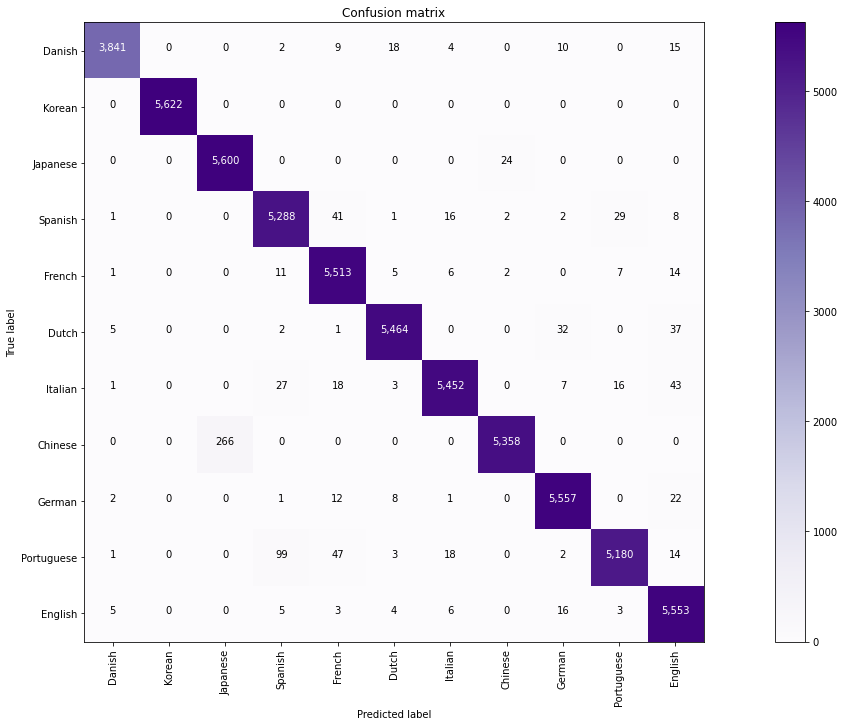

In [60]:
cm = confusion_matrix(sample["Language_English_Name"], sample["langid_language_English_Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

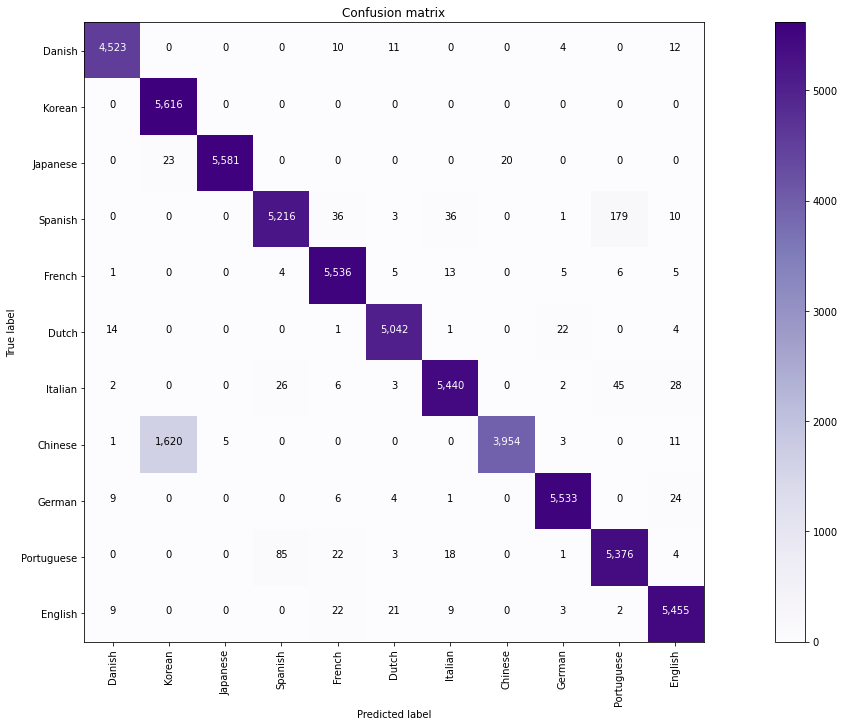

In [61]:
cm = confusion_matrix(sample["Language_English_Name"], sample["langdetect_language_English_Name"], labels)
plot_confusion_matrix(cm=cm, target_names=labels, normalize=False)

## Evaluate results as function of sentence length

In [62]:
from sklearn.metrics import f1_score

In [63]:
f1_score(sample["Language_English_Name"], sample["langid_language_English_Name"], labels=labels, average="weighted")

0.96161530940547

In [64]:
f1_score(sample["Language_English_Name"], sample["langdetect_language_English_Name"], labels=labels, average="weighted")

0.941361992975424

In [66]:
results = []
for this_bin in bin_labels:
    print(this_bin)
    
#     for i in range(0,100):        
#         temp_sample = sample[sample["bin"]==this_bin]
#         # find max sample size
#         max_sample_size = temp_sample["Language Full Name"].value_counts(normalize=False).min()
#         this_sample = temp_sample.groupby("Language Full Name", group_keys=False).apply(lambda x: x.sample(max_sample_size))

#         this_sample["langid"] = this_sample.apply(lambda row: list(lang_identifier.classify(row["Sentence"])), axis=1)
#         this_sample["langid_language"], this_sample["langid_score"] = this_sample["langid"].str
#         this_sample.drop(columns=["langid"], inplace=True)
#         this_sample["langid_language Full Name"] = this_sample["langid_language"].map(iso_639_1_names)

#         these_labels = this_sample["Language Full Name"].unique().tolist()

#         for lang in this_sample["langid_language Full Name"].unique():
#             these_results = this_sample[this_sample["langid_language Full Name"]==lang]

#             this_f1 = f1_score(these_results["Language Full Name"], these_results["langid_language Full Name"], labels=these_labels, average="weighted")
#             result = (this_bin, lang, round(this_f1,2))
#             results.append(result)

1
2
3
4
5
6
7
8
9
10
11 to 16
17 to 27
28 to 48
49 to 99


### Plot results

In [ ]:
import seaborn as sns

In [ ]:
# TODO: address inconsistent sample sizes (?)

In [ ]:
results = pd.DataFrame(data=results, columns=["Bin", "Language", "F1"])
results_pivot = results.pivot_table(values="F1", index="Language", columns="Bin")
results_pivot = results_pivot[bin_labels]
results_pivot.loc["Average"] = results_pivot.mean()

In [ ]:
# create custom colormap for consistent colors
language_cmap = {}
language_cmap["Average"] = (0.8901960784313725, 0.10196078431372549, 0.10980392156862745) # red-orange

language_cmap["Chinese"] = (0.5545098039215688, 0.7564167627835449, 0.8683121876201461) # blue
language_cmap["Japanese"] = (0.21568627450980393, 0.5294117647058824, 0.7542483660130719) # blue
language_cmap["Korean"] = (0.06251441753171857, 0.35750865051903113, 0.6429065743944637) # blue

language_cmap["French"] = (0.5739331026528259, 0.8241753171856978, 0.5606151480199923) # green
language_cmap["Italian"] = (0.21568627450980393, 0.6287581699346405, 0.3333333333333333) # green
language_cmap["Spanish"] = (0.04359861591695502, 0.4648212226066897, 0.20369088811995384) # green
language_cmap["Portuguese"] = (0.7792233756247597, 0.9132333717800846, 0.7518031526336024) # green

language_cmap["English"] = (0.698961937716263, 0.6965013456362938, 0.8372164552095348) # purple
language_cmap["Danish"] = (0.47320261437908495, 0.43267973856209146, 0.6993464052287581) # purple
language_cmap["German"] = (0.3568166089965398, 0.20525951557093425, 0.5856978085351787) # purple

# create custom dash dict for consistent dashes
language_dashes = {}
language_dashes["Average"] = (1, 1)

language_dashes["Chinese"] = (2, 1)
language_dashes["Japanese"] = (4, 3)
language_dashes["Korean"] = (6, 6)

language_dashes["French"] = (2, 1)
language_dashes["Italian"] = (4, 3)
language_dashes["Spanish"] = (6, 6)
language_dashes["Portuguese"] = (8, 12)

language_dashes["English"] = (2, 1)
language_dashes["Danish"] = (4, 3)
language_dashes["German"] = (6, 6)

In [ ]:
# ax = results_pivot.T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [ ]:
# ax = results_pivot.loc["Average"].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc["Average"].T, color=language_cmap["Average"], linestyle="dotted");
# plt.legend(loc="lower right");

In [ ]:
THESE_LANGUAGES = ["Chinese", "Japanese", "Korean"]
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [ ]:
THESE_LANGUAGES = ['Danish', 'English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [ ]:
THESE_LANGUAGES = ['Danish', 'English', 'German']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [ ]:
THESE_LANGUAGES = ['French', 'Italian', 'Portuguese', 'Spanish']
# ax = results_pivot.loc[THESE_LANGUAGES+["Average"]].T.plot(figsize=(20,10), title="Average F1 Score By Sentence Character Length", ylabel="F1 Score", xlabel="Sentence Character Length", ylim=(0.0,1.1));
# ax.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3)
# ax.set_xticks(range(len(bin_labels)));
# ax.set_xticklabels(bin_labels);
plt.figure(figsize=(30,10))
plt.title("Average F1 Score By Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
plt.axhline(y=0.8, linestyle="--", color="gray", alpha=0.3);
sns.lineplot(data=results_pivot.loc[THESE_LANGUAGES+["Average"]].T, palette=language_cmap, dashes=language_dashes);
plt.legend(loc="lower right");

In [ ]:
# number of chars needed to be above 0.8 F1

In [ ]:
results_pivot

In [ ]:
# find the first bin where average F1 exceeds 0.8 & stays above 0.8 for the remainder

In [ ]:
_80 = results_pivot.apply(lambda row: row[row > 0.79].index[0], axis=1)
_90 = results_pivot.apply(lambda row: row[row > 0.89].index[0], axis=1)
results_pivot["First Bin >= 0.8"] = _80
results_pivot["First Bin >= 0.9"] = _90
results_pivot

In [ ]:
results_pivot["First Bin >= 0.8"].sort_values()

In [ ]:
results_pivot["First Bin >= 0.9"].sort_values()

In [ ]:
# TODO: evaluate langdetect & textblob libs
# TODO: evaluate impact of lowercasing, removing punctuation, removing numbers